In [11]:
#We will make a basic CNN model to classify CIFAR-10#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.random import gamma as tf_random_gamma
from tensorflow import data as tf_data
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

#show the tensorflow version
print(tf.__version__)


2.10.1


In [12]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9615935436646664602
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10395333871088788457
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0
# Convert data to one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


## Model (Mix-up + TSLA)

## Input with Mixup Regularization

In [14]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 40

In [15]:

train_ds_one = (
    tf_data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))


test_ds = tf_data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [16]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random_gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random_gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]  # Use tf instead of keras

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Cast the lambda tensors to the same data type as the images tensors
    x_l = tf.cast(x_l, images_one.dtype)
    y_l = tf.cast(y_l, labels_one.dtype)

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)



[0.7182443141937256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.281755656003952, 0.0]
[0.0, 0.0, 0.0, 0.4878883361816406, 0.0, 0.0, 0.0, 0.0, 0.5121116638183594, 0.0]
[0.0, 0.0, 0.0, 0.00016129016876220703, 0.0, 0.0, 0.0, 0.9998387098312378, 0.0, 0.0]
[0.0, 0.0, 0.9999885559082031, 1.1444091796875e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.7997332215309143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2002667784690857, 0.0, 0.0]
[0.0, 0.0, 0.9449203610420227, 0.0, 0.05507964268326759, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.9595754742622375, 0.0, 0.04042453318834305, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.11154663562774658, 0.8884533643722534, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4524551033973694, 0.0, 0.0, 0.5475448966026306]


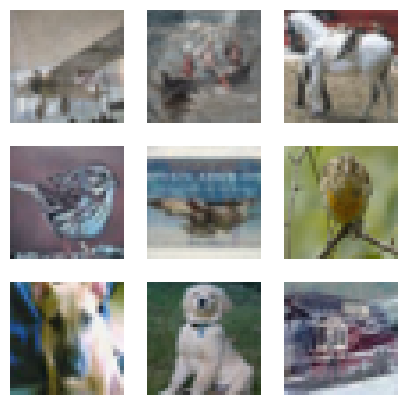

In [17]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=AUTO,
)


# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(5, 5))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

## Baseline Model

In [64]:
#Build model

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
# model.summary()



In [65]:
#Train the models
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#one hot labels
y_train_1hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_1hot = tf.keras.utils.to_categorical(y_test, 10)
#two stage label smoothing on model 2 with first epoch with label smoothing and the rest without LS
model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
history = model.fit(train_ds_mu, epochs=2, validation_data=test_ds, callbacks=[tensorboard_callback])
model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy',TopKCategoricalAccuracy(k=3)])
#concatenate to history2
history_2 = model.fit(train_ds_mu, epochs=18, validation_data=test_ds, callbacks=[tensorboard_callback])
#concatenate history2 and history2_2
history.history['loss'] += history_2.history['loss']
history.history['accuracy'] += history_2.history['accuracy']
history.history['val_loss'] += history_2.history['val_loss']
history.history['val_accuracy'] += history_2.history['val_accuracy']
history.history['val_top_k_categorical_accuracy'] += history_2.history['val_top_k_categorical_accuracy']
history.history['top_k_categorical_accuracy'] += history_2.history['top_k_categorical_accuracy']

Epoch 1/2
782/782 [==============================] - 8s 9ms/step - loss: 1.9209 - accuracy: 0.4103 - top_k_categorical_accuracy: 0.7368 - val_loss: 1.6219 - val_accuracy: 0.5651 - val_top_k_categorical_accuracy: 0.8632
Epoch 2/2
782/782 [==============================] - 7s 9ms/step - loss: 1.6482 - accuracy: 0.6130 - top_k_categorical_accuracy: 0.8760 - val_loss: 1.4618 - val_accuracy: 0.6734 - val_top_k_categorical_accuracy: 0.9065
Epoch 1/18
782/782 [==============================] - 8s 9ms/step - loss: 1.0930 - accuracy: 0.6909 - top_k_categorical_accuracy: 0.9089 - val_loss: 0.8411 - val_accuracy: 0.7140 - val_top_k_categorical_accuracy: 0.9244
Epoch 2/18
782/782 [==============================] - 7s 9ms/step - loss: 0.9984 - accuracy: 0.7336 - top_k_categorical_accuracy: 0.9257 - val_loss: 0.7708 - val_accuracy: 0.7377 - val_top_k_categorical_accuracy: 0.9317
Epoch 3/18
782/782 [==============================] - 7s 9ms/step - loss: 0.9343 - accuracy: 0.7660 - top_k_categorical_ac

## Store loss & accuracy

In [66]:
#store training loss and validation loss as a numpy array
np.save('./train_data/train_loss.npy', history.history['loss'])
np.save('./train_data/val_loss.npy', history.history['val_loss'])
#store accuracy and validation accuracy as a numpy array
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
np.save('./train_data/train_accuracy.npy', train_accuracy)
np.save('./train_data/val_accuracy.npy', val_accuracy)
#store top 3 accuracy and validation top 3 accuracy as a numpy array
train_top3_accuracy = history.history['top_k_categorical_accuracy']
val_top3_accuracy = history.history['val_top_k_categorical_accuracy']
np.save('./train_data/train_top3_accuracy.npy', train_top3_accuracy)
np.save('./train_data/val_top3_accuracy.npy', val_top3_accuracy)



In [67]:
#print train_top3_accuracy
print(train_top3_accuracy)
#print val_top3_accuracy
print(val_top3_accuracy)

[0.7368199825286865, 0.876039981842041, 0.9089000225067139, 0.9256799817085266, 0.9372599720954895, 0.9460999965667725, 0.9513199925422668, 0.9567199945449829, 0.9605600237846375, 0.9642199873924255, 0.9657800197601318, 0.9689800143241882, 0.9702799916267395, 0.9709799885749817, 0.9737200140953064, 0.9733999967575073, 0.9746400117874146, 0.9753000140190125, 0.9755799770355225, 0.9766200184822083]
[0.8632000088691711, 0.906499981880188, 0.9243999719619751, 0.9316999912261963, 0.9401000142097473, 0.9354000091552734, 0.9394000172615051, 0.9387999773025513, 0.9437999725341797, 0.940500020980835, 0.9435999989509583, 0.9358999729156494, 0.9312000274658203, 0.9369999766349792, 0.9361000061035156, 0.935699999332428, 0.9347000122070312, 0.9362000226974487, 0.9341999888420105, 0.9355000257492065]


## load loss & accuracy

In [68]:
#load the loss and accuracy data
train_loss = np.load('./train_data/train_loss.npy')
val_loss = np.load('./train_data/val_loss.npy')
train_accuracy = np.load('./train_data/train_accuracy.npy')
val_accuracy = np.load('./train_data/val_accuracy.npy')
train_top3_accuracy = np.load('./train_data/train_top3_accuracy.npy')
val_top3_accuracy = np.load('./train_data/val_top3_accuracy.npy')



## Plot

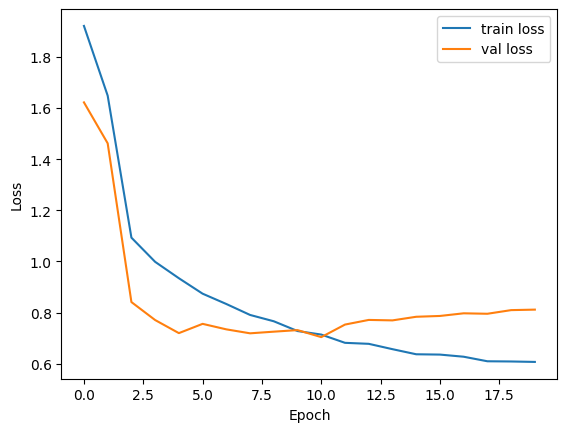

In [69]:
#plot loss
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label = 'val loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
#legend
plt.legend(loc='upper right')
#show plot
plt.show()


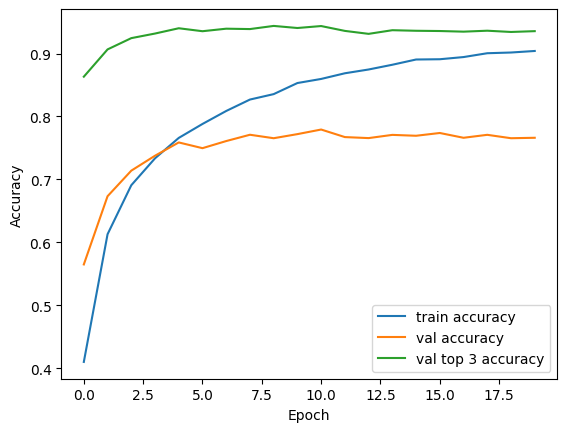

In [70]:
#plot accuracy
plt.plot(train_accuracy, label='train accuracy')
plt.plot(val_accuracy, label = 'val accuracy')
plt.plot(val_top3_accuracy, label = 'val top 3 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#legend
plt.legend(loc='lower right')
#show plot
plt.show()


In [71]:
#max accuracy
print(max(val_accuracy))
print(max(val_top3_accuracy))

0.7792999744415283
0.9437999725341797


313/313 [==============================] - 1s 2ms/step


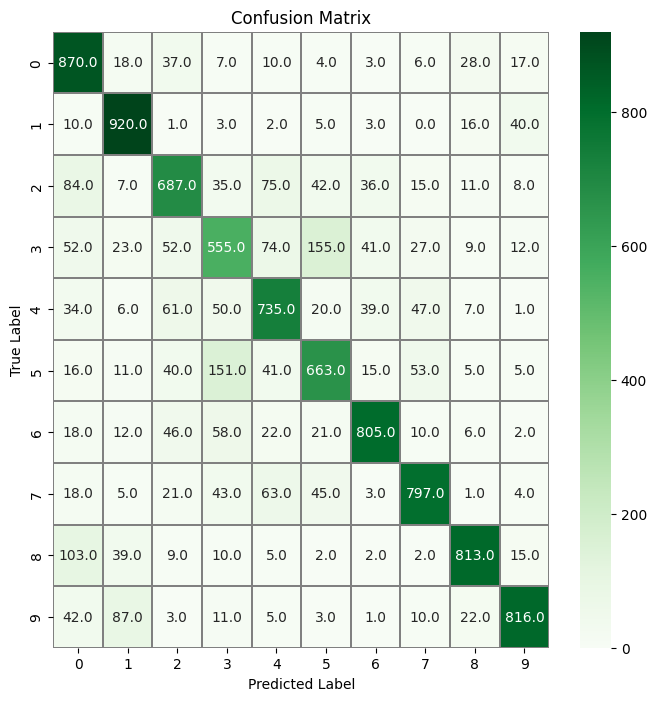

In [72]:
## CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.squeeze(y_test)
#change Y_true from One hot encoding to integers
Y_true = np.argmax(Y_true, axis = 1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
#plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()





## Save the trained Model

In [73]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights.h5')


## Load the trained Model

In [74]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar100_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar100_cnn_weights.h5')